In [1]:
import os
from pathlib import Path

import sys
sys.path.append('..')


from babilong.metrics import compare_answers, TASK_LABELS

import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np

## Visualize evaluation results

In [ ]:
results_folder =  Path('../babilong_evals')
model_names = []
for path in results_folder.glob('*/*'):
    model_names += [f'{path.parent.name}/{path.name}']
# print(model_names)

In [3]:
model_names = [
               # 'openai/gpt-4-0125-preview', 'openai/gpt-4o-mini-2024-07-18',
               # 'meta-llama/Llama-3.2-3B-Instruct', 'meta-llama/Meta-Llama-3.1-8B-Instruct', 'meta-llama/Meta-Llama-3.1-70B-Instruct',
               # 'Qwen/Qwen2.5-7B-Instruct', 'Qwen/Qwen2.5-72B-Instruct',
               'google/gemma-2-9b-it', 'google/gemma-3-4b-it', 'google/gemma-3-12b-it', 'google/gemma-3-27b-it',
               'microsoft/Phi-3.5-mini-instruct', 'microsoft/Phi-4-mini-instruct',
               'NX-AI/xLSTM-7b',
               ]
tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']
lengths = ['0k', '1k', '2k', '4k', '8k', '16k', '32k', '64k', '128k']#, '512k', '1M']

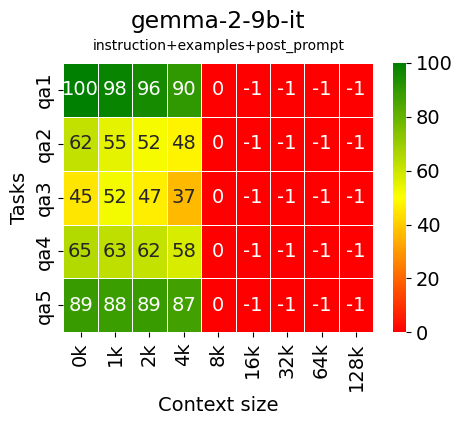

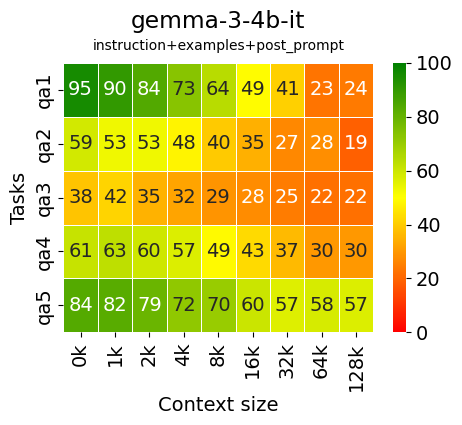

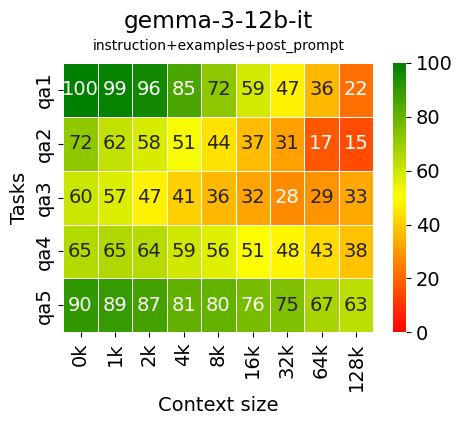

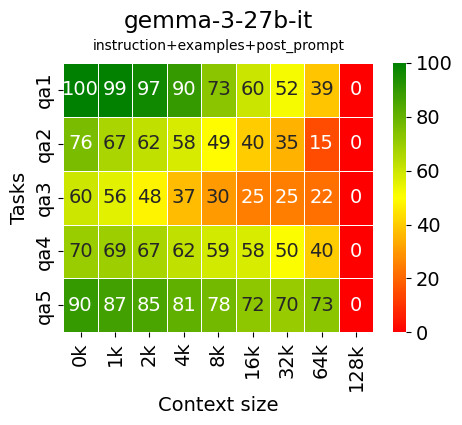

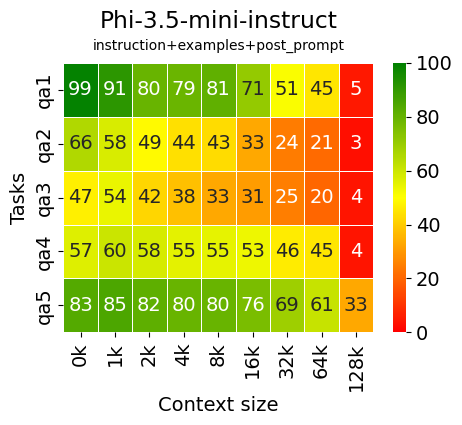

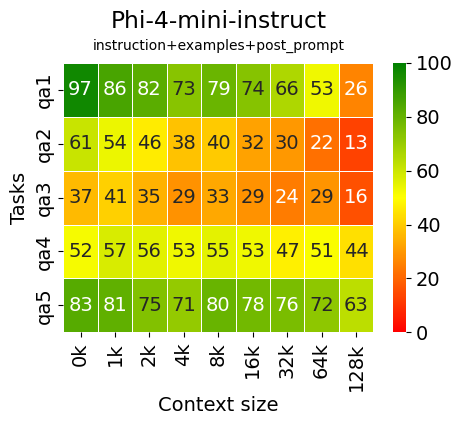

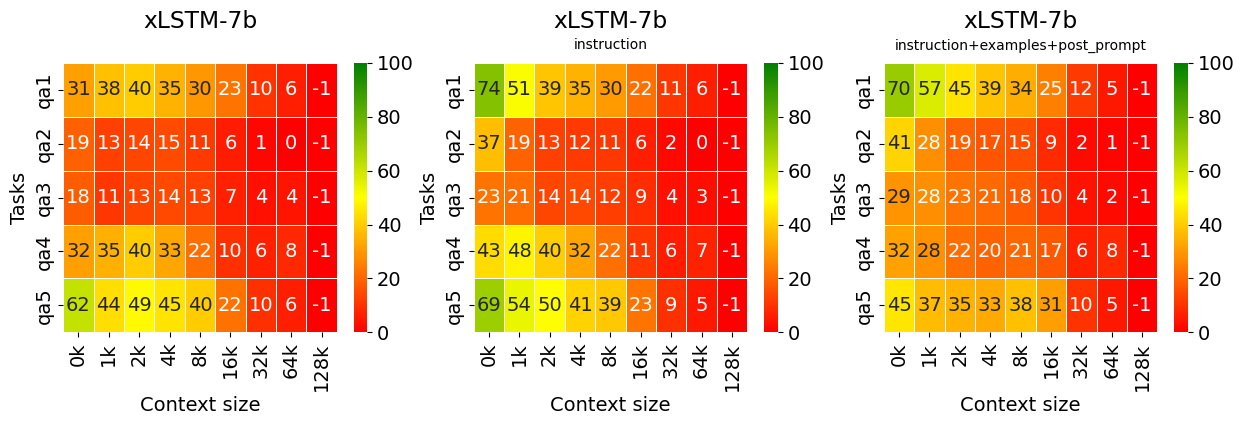

In [4]:
def parse_run_cfg(cfg_str):
    parts = cfg_str.split('_')
    result = {}
    key_parts = []
    for p in parts:
        if p in ("yes", "no"):
            key = "_".join(key_parts)
            result[key] = (p == "yes")
            key_parts = []
        else:
            key_parts.append(p)
    return result

results = {}

for model_name in model_names:
    model_results_folder = results_folder / model_name
    run_configurations = set()
    for fn in model_results_folder.glob('*.csv'):
        run_configurations.add('_'.join(fn.stem.split('_')[2:]))

    if len(run_configurations) > 0:
        results[model_name] = {}

    for run_cfg in run_configurations:
        accuracy = np.ones((len(tasks), len(lengths))) * -1
        for j, task in enumerate(tasks):
            for i, ctx_length in enumerate(lengths):
                fname = model_results_folder / f'{task}_{ctx_length}_{run_cfg}'
                results_fname = fname.with_suffix('.csv')
                cfg_fname = fname.with_suffix('.json')
                if not results_fname.exists():
                    continue

                df = pd.read_csv(results_fname)
                    
                if df['output'].dtype != object:
                    df['output'] = df['output'].astype(str)
                df['output'] = df['output'].fillna('')


                df['correct'] = df.apply(lambda row: compare_answers(target=row['target'], output=row['output'],
                                                                    question=row['question'],
                                                                    task_labels=TASK_LABELS[task]), axis=1)
                score = df['correct'].sum()
                accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0
                results[model_name][run_cfg] = accuracy

    model_results = results[model_name]
    # Set large font sizes for better visibility in the PDF
    matplotlib.rc('font', size=14)
    # Create a colormap for the heatmap
    cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

    # Create the heatmap
    fig, axes = plt.subplots(1, len(model_results), figsize=(5 * len(model_results), 3.5))
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    for i, run_cfg in enumerate(sorted(model_results.keys())):
        sns.heatmap(model_results[run_cfg], cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
                    linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=axes[i])
        
        cfg_string = ''
        for k, v in parse_run_cfg(run_cfg).items():
            if v and k not in ['chat_template', 'system_prompt']:
                cfg_string += f'{k}+'
        cfg_string = cfg_string[:-1]

        # Set the main title.
        axes[i].set_title(f"{model_name.split('/')[-1]}\n")
        # Add a second line with a smaller font, positioned above the axis.
        axes[i].text(0.5, 1.05, cfg_string, transform=axes[i].transAxes, ha='center', fontsize=10)
        axes[i].set_xlabel('Context size')
        axes[i].set_ylabel('Tasks')
    # Save the figure to a PDF
    # plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
    plt.show()

### Visualize the results for copy-paste format

In [5]:
results.keys()

dict_keys(['google/gemma-2-9b-it', 'google/gemma-3-4b-it', 'google/gemma-3-12b-it', 'google/gemma-3-27b-it', 'microsoft/Phi-3.5-mini-instruct', 'microsoft/Phi-4-mini-instruct', 'NX-AI/xLSTM-7b'])

In [6]:
pd.set_option('display.max_colwidth', None)

In [8]:
mn = 'NX-AI/xLSTM-7b'

best_tab = None
best_avgs = {}
best_cfgs = {}  # Store best config for each task

# Go through each configuration
for cfg in results[mn].keys():
    tab = results[mn][cfg]
    tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])
    tab['len_avg'] = tab.mean(axis=1)
    print(f'{mn}\n{cfg}')
    display(tab.iloc[:,:-1].round().astype(int))
    
    # For each task, check if this config gives better results
    for task in tasks:
        curr_avg = tab.loc[task, 'len_avg']
        if task not in best_avgs or curr_avg > best_avgs[task]:
            if best_tab is None:
                best_tab = tab.copy()
                best_tab['best_cfg'] = ''  # Add column for best configs
            best_tab.loc[task] = tab.loc[task]
            best_tab.loc[task, 'best_cfg'] = cfg
            best_avgs[task] = curr_avg
            best_cfgs[task] = cfg

# Add average row
best_tab.loc['avg'] = best_tab.iloc[:,:-2].mean(axis=0)
best_tab.loc['avg', 'best_cfg'] = 'N/A'

display_cols = list(best_tab.columns[:-2]) + ['best_cfg']

print(f'{mn}\nbest setups:')
display(best_tab[display_cols].round().astype({col: int for col in best_tab.columns[:-2]}))
display(best_tab[display_cols[:-1]].round().astype({col: int for col in best_tab.columns[:-2]}))

NX-AI/xLSTM-7b
instruction_yes_examples_no_post_prompt_no_chat_template_no_system_prompt_yes


,0k,1k,2k,4k,8k,16k,32k,64k,128k
qa1,74,51,39,35,30,22,11,6,-1
qa2,37,19,13,12,11,6,2,0,-1
qa3,23,21,14,14,12,9,4,3,-1
qa4,43,48,40,32,22,11,6,7,-1
qa5,69,54,50,41,39,23,9,5,-1


NX-AI/xLSTM-7b
instruction_yes_examples_yes_post_prompt_yes_chat_template_no_system_prompt_yes


,0k,1k,2k,4k,8k,16k,32k,64k,128k
qa1,70,57,45,39,34,25,12,5,-1
qa2,41,28,19,17,15,9,2,1,-1
qa3,29,28,23,21,18,10,4,2,-1
qa4,32,28,22,20,21,17,6,8,-1
qa5,45,37,35,33,38,31,10,5,-1


NX-AI/xLSTM-7b
instruction_no_examples_no_post_prompt_no_chat_template_no_system_prompt_yes


,0k,1k,2k,4k,8k,16k,32k,64k,128k
qa1,31,38,40,35,30,23,10,6,-1
qa2,19,13,14,15,11,6,1,0,-1
qa3,18,11,13,14,13,7,4,4,-1
qa4,32,35,40,33,22,10,6,8,-1
qa5,62,44,49,45,40,22,10,6,-1


NX-AI/xLSTM-7b
best setups:


,0k,1k,2k,4k,8k,16k,32k,64k,128k,best_cfg
qa1,70,57,45,39,34,25,12,5,-1,instruction_yes_examples_yes_post_prompt_yes_chat_template_no_system_prompt_yes
qa2,41,28,19,17,15,9,2,1,-1,instruction_yes_examples_yes_post_prompt_yes_chat_template_no_system_prompt_yes
qa3,29,28,23,21,18,10,4,2,-1,instruction_yes_examples_yes_post_prompt_yes_chat_template_no_system_prompt_yes
qa4,43,48,40,32,22,11,6,7,-1,instruction_yes_examples_no_post_prompt_no_chat_template_no_system_prompt_yes
qa5,69,54,50,41,39,23,9,5,-1,instruction_yes_examples_no_post_prompt_no_chat_template_no_system_prompt_yes
avg,51,43,35,30,26,15,6,4,-1,N/A


,0k,1k,2k,4k,8k,16k,32k,64k,128k
qa1,70,57,45,39,34,25,12,5,-1
qa2,41,28,19,17,15,9,2,1,-1
qa3,29,28,23,21,18,10,4,2,-1
qa4,43,48,40,32,22,11,6,7,-1
qa5,69,54,50,41,39,23,9,5,-1
avg,51,43,35,30,26,15,6,4,-1
